----

[Link to this document's Jupyter Notebook](HW2-Affine_transform.ipynb)

In order to successfully complete this assignment, you must follow all the instructions in this notebook and upload your edited ipynb file to [D2L](http://d2l.msu.edu/) with your answers on or before **11:59pm on Friday February 19th**.

**BIG HINT:** Read the entire homework before starting.  

# Homework 2: Affine Transform


In this homework you will use the ```ipywidgets.interact``` (or ```ipywidgets.interact_manual```) function to build a interface to translate, scale, rotate and shear an image using ```skimage.transform``` and ```skimage.transform.warp``` (http://scikit-image.org/).  We will then "stitch" the images together similar to the following:


<img src="https://lh5.googleusercontent.com/T7SNdiXctkIi2iWHjjdAZCRBASzRjysFkmivxtD8cZ80QlKFPjOeYa--uiDoHEUdb7daadZQ-fW-l0SVBQJDj90vPFaCKke9JSf6jf8Rk71zpy62TP_hmBpdFONBoA=w740" alt="An figure showing how we will be stitching images together"> 

## Homework Agenda

1. [Reading in example image files](#Reading-in-example-image-files)
2. **_[Design Transforms](#Design-Transforms)_**
3. [Stitch Images together](#Stitch-Images-together)
4. **_[Build an combined affine transform function.](#Build-an-combined-affine-transform-function.)_**
5. [Exploring Transforms Interactively](#Exploring-Transforms-Interactively)
6. **_[Stitching the Billboad and Example images](#Stitching-the-Billboad-and-Example-images)_**
7. **_[Be creative](#Be-creative)_**

**_NOTE_**: Highlighted sections above (2,4,6,7) require the majority of student input. The rest are mostly intended to glue the project together and facilitate learning.

In [28]:
# Here are some libraries you may need to use
%matplotlib inline
import matplotlib.pylab as plt

import sympy as sp
sp.init_printing()

import numpy as np

from ipywidgets import interact, interact_manual
import math




---
<a name=Reading-in-example-image-files></a>
# 1. Reading in example image files




The following code reads a list of image files from a website and saves them in their own 3D numpy arrays.  The first dimension of each array is the row, the second dimension is the column and the third dimension is the color (R,G,B). 


**NOTE (this is important to remember):** images have a coordinate system with origin in the upper left and the $z$ axis going into the screen. Also, images are indexed by [Rows] and then [Columns]. This means that the first index corresponds to the traditional y-axis and the second index corresponds to the x-axis (which is backwards to traditional euclidean axes).

In [96]:
#The following code snip-it downloads the files from internet and saves tnhem to your local directory.
from urllib.request import urlopen, urlretrieve
import imageio

#Load a list of images
ImageList = [('beaumont', 'http://res.cloudinary.com/miles-extranet-dev/image/upload/ar_16:9,c_fill,w_1000,g_face,q_50/Michigan/migration_photos/G21696/G21696-msubeaumonttower01.jpg'
),
             ('sparty','https://cdn.shopify.com/s/files/1/1058/4992/products/MSU-Gruffy-Sparty-Sticker-550_620x.jpg?v=1525615105'),
             ('billboard', 'https://lh4.googleusercontent.com/OA8Et4hB-vpuYTKt86gk9i_Or1ptNbxtuYnR-7vujPVuVx6m30wXoVE3_d5fG_xDYAxUmDxOUw=w600'),
             ('banner', 'https://lh4.googleusercontent.com/aORranhBKm_pVs-Mg_pkyY1e8ujLh_7Y671d2BjNrWPiagBqktcJvD34ZHgUQrgbFAj4xOcf0Q=w740'),
             ('img_1', 'https://raw.githubusercontent.com/kushalvyas/Python-Multiple-Image-Stitching/master/images/1.jpg'),
             ('img_2', 'https://raw.githubusercontent.com/kushalvyas/Python-Multiple-Image-Stitching/master/images/2.jpg')

            ]

for name, url in ImageList:
    print(name)
    file = name+'.png'
    urlretrieve(url, file);
    exec(name + " = imageio.imread(file)")

beaumont
sparty
billboard
banner
img_1
img_2


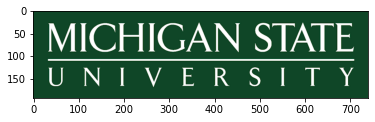

In [32]:
#Pick an image and show it
im = banner
plt.imshow(im);


---
<a name=Design-Transforms></a>
# 2. (20 points)  Design Transforms



The skimage library allows us to apply a $3 \times 3$ transformation matrix to an image using the ```transform.warp``` function.

```warp```  uses an ```Inverse coordinate map``` as an input, which transforms coordinates in the output images ($P_o$) into their corresponding coordinates in the input image ($P_i$). This means we need to think about what we want the output image to look like and apply all of the transformations to get it to the original input image.


$$P_i = TP_o$$

Where $P_o$ is a point in the output image, $P_i$ is a point in the input image and $T$ is the $3x3$ image transform.


For example, if we want to have our output image shrink by a half, this typically would be a contraction:

$$A = \left[ \begin{matrix}0.5 & 0 & 0 \\ 0 & 0.5 & 0 \\ 0 & 0 & 1 \end{matrix}\right]$$

However, warp wants transforms that go from output image to input image. This means we want to double the size of the image, which can be done with a dilation:

$$B = \left[ \begin{matrix}2 & 0 & 0 \\ 0 & 2 & 0 \\ 0 & 0 & 1 \end{matrix}\right]$$

Also note that $A^{-1} = B$.

Here is an example of how to use the ```transform.warp``` function:

⎡2  0  0⎤
⎢       ⎥
⎢0  2  0⎥
⎢       ⎥
⎣0  0  1⎦

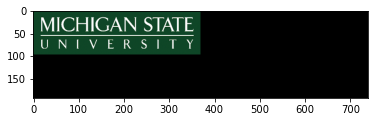

In [33]:
from skimage import transform

S = np.matrix([[2,0,0], [0,2,0], [0,0,1]])
plt.imshow(transform.warp(im,S));
sp.Matrix(S)

What we really want is the output image to be centered. Since most transformations are symmetric around the origin, that means we want to move the center of the image to the origin first (at least for scaling, rotation and shear).  In our scaling example, to go from a centered output, we would first translate it from the center to the origin and then scale the image and translate it back to the center using the following transforms:

In [34]:
# Translate image to put the center at the origin
Tc = np.matrix([[1,0,-im.shape[1]/2], [0,1,-im.shape[0]/2], [0,0,1]])
sp.Matrix(Tc)

⎡1.0  0.0  -370.0⎤
⎢                ⎥
⎢0.0  1.0  -96.0 ⎥
⎢                ⎥
⎣0.0  0.0   1.0  ⎦

In [35]:
# translate image back so that the upper left point is at the origin

To = np.matrix([[1,0,im.shape[1]/2], [0,1,im.shape[0]/2], [0,0,1]])
sp.Matrix(To)

⎡1.0  0.0  370.0⎤
⎢               ⎥
⎢0.0  1.0  96.0 ⎥
⎢               ⎥
⎣0.0  0.0   1.0 ⎦

In [36]:
#Combine the transforms into one matrix
T = To*S*Tc
sp.Matrix(T)

⎡2.0  0.0  -370.0⎤
⎢                ⎥
⎢0.0  2.0  -96.0 ⎥
⎢                ⎥
⎣0.0  0.0   1.0  ⎦

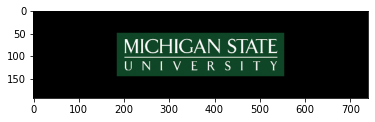

In [37]:
plt.imshow(transform.warp(im, T));

&#9989;  **<font color=red>DO THIS:</font>** Construct another transformation matrix (named ```R```) that rotates the image 30 degrees (clockwise) around it's center.  Apply this new matrix such that we get a scaled and rotated image T.  Show the image and make sure it has in fact rotated by 30 degrees in the clockwise direction.

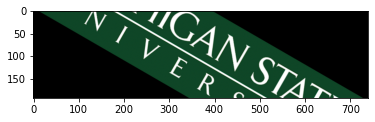

In [38]:
#Put your rotation code here.
R = np.matrix([[np.cos(np.radians(30))  , np.sin(np.radians(30))  , 0], 
               [-np.sin(np.radians(30)) , np.cos(np.radians(30))  , 0], 
               [0                       , 0                       , 1]])
sp.Matrix(R)

RT = To*R*Tc
sp.Matrix(RT)

plt.imshow(transform.warp(im, RT));

In [39]:
from answercheck import checkanswer

checkanswer.matrix(R,"84b1a7ebd71e740c41730448de079684");


    Converting to positive values of zero using  ```A[A==-0] = 0```.

Testing [[ 0.86603  0.5      0.     ]
 [-0.5      0.86603  0.     ]
 [ 0.       0.       1.     ]]
Answer seems to be correct



&#9989;  **<font color=red>DO THIS:</font>** write a third transformation matrix (named ```SH```) that conducts a shear of the image. The matrix should be in the following form. To test this matrix use shx=-0.3 and shy=0.1:

$$A = \left[ \begin{matrix}1 & shx & 0 \\ shy & 1 & 0 \\ 0 & 0 & 1 \end{matrix}\right]$$

Apply this new matrix such that we get a scaled and sheared image.  Show the image. 


**Note:** the term shear may be new. here is a good matrix definition: https://www.mathworks.com/discovery/affine-transformation.html


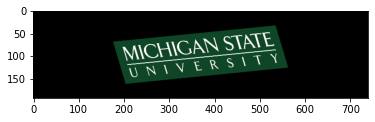

In [40]:
#Put your shear code here.
shx, shy = -0.3, 0.1
SH= np.matrix([[1   , shx , 0], 
               [shy , 1   , 0], 
               [0   , 0   , 1]])
sp.Matrix(SH)

SHT = To*S*SH*Tc
sp.Matrix(SHT)

plt.imshow(transform.warp(im, SHT));

In [41]:
#Check the Combined R and S matrix
from answercheck import checkanswer
checkanswer.matrix(SH,"b1259119454dbd7349c4ed47c1dea64a");


    Converting to positive values of zero using  ```A[A==-0] = 0```.

Testing [[ 1.  -0.3  0. ]
 [ 0.1  1.   0. ]
 [ 0.   0.   1. ]]
Answer seems to be correct



---
<a name=Stitch-Images-together></a>
# 3. Stitch Images together



Lets use this technique to "stitch" two images together. This is a little tricky so we will use the following function (You do not need to modify this function or anything in section 3). This function takes three inputs; the foreground image (i.e. the image to be transformed, the background image and the corresponding transform:

In [42]:
def stitch_images(forground, background, T):
    """Function to stitch to images together by transforming the forground image by T 
    and then overlaying the resulting image on top of the background
    
    background: the background image to use
    forground: the image to be transformed
    T: 3x3 transformation matrix
    
    output: stitched image the same size as the background.
    
    """
    
    warpped_img = transform.warp(forground, T, output_shape=background.shape)
    
    if background.shape != warpped_img.shape:
        raise Exception('Size Missmatch Error - Input images should be the same size')
    
    if (len(background.shape) != 3):
        raise Exception('Image Type error - Images should be in RGB format')
            
    red_src = np.array(background[:,:,0])
    green_src = np.array(background[:,:,1])
    blue_src = np.array(background[:,:,2])

    scale = 1
    if (np.max(warpped_img) == 1):
        scale = 255.0
        
    red_dst = warpped_img[:,:,0]*scale
    green_dst = warpped_img[:,:,1]*scale
    blue_dst = warpped_img[:,:,2]*scale

    image_mask = (np.sum(warpped_img, axis=2) == 0)
    
    red_new = red_src*image_mask
    green_new = green_src*image_mask
    blue_new = blue_src*image_mask
    
    im_new = np.zeros(background.shape)
    im_new[:,:,0] = (red_new + red_dst)/255
    im_new[:,:,1] = (green_new + green_dst)/255
    im_new[:,:,2] = (blue_new + blue_dst)/255
    
    return im_new

We can test the above function using the results of your previous transforms:

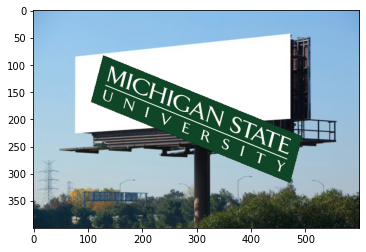

In [43]:
Tc = np.matrix([[1,0,-billboard.shape[1]/2], [0,1,-billboard.shape[0]/2], [0,0,1]])
To = np.matrix([[1,0,banner.shape[1]/2], [0,1,banner.shape[0]/2], [0,0,1]])
plt.imshow(stitch_images(banner, billboard, To*R*S*SH*Tc))



---
<a name=Build-an-combined-affine-transform-function.></a>
# 4. (50 points) Build an combined affine transform function.



In this step, you will write a function that takes affine parameters as inputs and returns a combined $3 \times 3$ matrix. 

&#9989;  **<font color=red>DO THIS:</font>** Write a function that takes seven inputs and returns a transformation T. Name this function ```affine_transform```. These include the following:

- **a** - Rotation around the center of the image [-$180$,$180$].  
- **sx** - Sale factor for the image in the x direction (0,5]
- **sy** - Sale factor for the image in the x direction (0,5]
- **tx** - translation in the x direction (pixels)
- **ty** - translation in the y direction (pixels)
- **shx** - Shear in the x direction [0,1]
- **shy** - Shear in the y direction [0,1]

The order of these is very important. First, assume the image is already centered, then apply shear, scaling, rotation, and finish with translation. 

In [83]:
##Put your function here
def affine_transform(a=0,sx=0.5, sy=0.5,tx=0,ty=0,shx=0, shy=0):
    T = np.matrix([[1,0,0],[0,1,0],[0,0,1]])
    # TRANSLATION MATRIX
    TM  = np.matrix([ [1    , 0   , -tx], 
                      [0    , 1   , ty], 
                      [0   , 0  , 1] ])

    # SHEAR MATRIX
    SH  = np.matrix([ [1   , shx , 0], 
                      [shy , 1   , 0], 
                      [0   , 0   , 1] ])

    # SCALE MATRIX
    S   = np.matrix([ [sx   , 0   , 0], 
                      [0    , sy  , 0], 
                      [0    , 0   , 1] ])

    # ROTATION MATRIX
    R   = np.matrix([ [np.cos(np.radians(a))  , np.sin(np.radians(a))   , 0], 
                      [-np.sin(np.radians(a)) , np.cos(np.radians(a))   , 0], 
                      [0                      , 0                       , 1]]  )
    # FINAL TRANSFORMATION MATRIX 
    T   = TM*R*S*SH
    return T

**_NOTE_**:  The following tests are intended to help students (and facilitate grading), however, the instructors are aware that there are multiple correct answers that may may cause these tests to fail.    


    Converting to positive values of zero using  ```A[A==-0] = 0```.

Testing [[0.5 0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  1. ]]
Answer seems to be incorrect



AssertionError: Answer is incorrect dea2773bc70fccffc5cbd81a383f5d3f

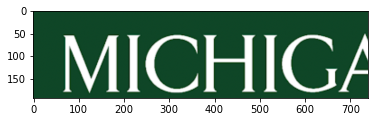

In [84]:
from answercheck import checkanswer
test1 = affine_transform()
plt.imshow(transform.warp(im, test1));
checkanswer.matrix(test1,"d6bd760cffe3502ce411af2b8e771532");



    Converting to positive values of zero using  ```A[A==-0] = 0```.

Testing [[ 4.3301e-01  2.5000e-01 -4.0000e+02]
 [-2.5000e-01  4.3301e-01 -3.0000e+02]
 [ 0.0000e+00  0.0000e+00  1.0000e+00]]
Answer seems to be incorrect



AssertionError: Answer is incorrect 3fd35f532f7724c8f64d3f70f35be210

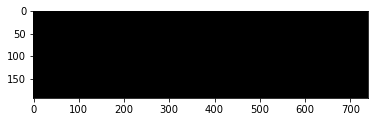

In [85]:
from answercheck import checkanswer
test2 = affine_transform(a=30,tx=400, ty=-300)
plt.imshow(transform.warp(im, test2));
checkanswer.matrix(test2,"c61fa880d8bc72fd27601914ec7b75e1");



    Converting to positive values of zero using  ```A[A==-0] = 0```.

Testing [[ 4.1692e-01  2.8716e-01 -8.0000e+02]
 [-2.4040e-02  3.2115e-01  5.0000e+01]
 [ 0.0000e+00  0.0000e+00  1.0000e+00]]
Answer seems to be incorrect



AssertionError: Answer is incorrect e4ba94700270b5bb927e860621b97f0b

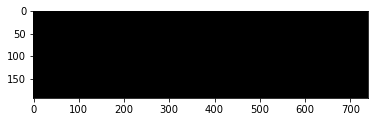

In [86]:
from answercheck import checkanswer
test3 = affine_transform(a=20, sx=0.4, sy=0.4, shx=0.4, shy=0.3, tx=800, ty=50)
plt.imshow(transform.warp(im, test3));
checkanswer.matrix(test3,"bbec7cab05358167646fb39245115e08");



    Converting to positive values of zero using  ```A[A==-0] = 0```.

Testing [[ 5.0e-01  5.0e-02 -1.0e+02]
 [ 1.5e-01  5.0e-01  2.5e+02]
 [ 0.0e+00  0.0e+00  1.0e+00]]
Answer seems to be incorrect



AssertionError: Answer is incorrect 46b962a8dc8aaf18466e8fd9ead7236c

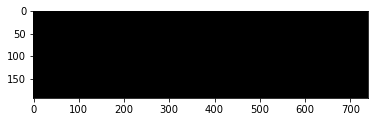

In [51]:
from answercheck import checkanswer
test4 = affine_transform(shx=0.1, shy=0.3, tx=100,ty=250)
plt.imshow(transform.warp(im, test4));
checkanswer.matrix(test4,"cf7f10d5430697093533c4e263992fac");


    Converting to positive values of zero using  ```A[A==-0] = 0```.

Testing [[   0.5    0.  -400. ]
 [   0.     0.5  100. ]
 [   0.     0.     1. ]]
Answer seems to be incorrect



AssertionError: Answer is incorrect 61a1098b2db052524080a84520f15f18

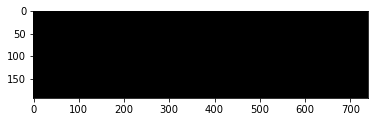

In [87]:
from answercheck import checkanswer
test5 = affine_transform(tx=400,ty=100)
plt.imshow(transform.warp(im, test5));
checkanswer.matrix(test5,"85607ee2bbf4b4759e1e6da6728b392c");




---
<a name=Exploring-Transforms-Interactively></a>
# 5. (10 points) Exploring Transforms Interactively

In this final step, using the ```ipywidgets.interact``` (or ```ipywidgets.interact_manual```) function to call your ```affine_transform``` function will turn all of the input parameters into sliders. 

**_Note_**: if the ```affine_transform``` function was created correctly in Step 3, then the following function does not need to be changed and should work similar to the video at the beginning of this homework. 

Here is a video similar (not exact) of what your final solution will look like:

* Direct Link: https://youtu.be/b4x39uqTMBY

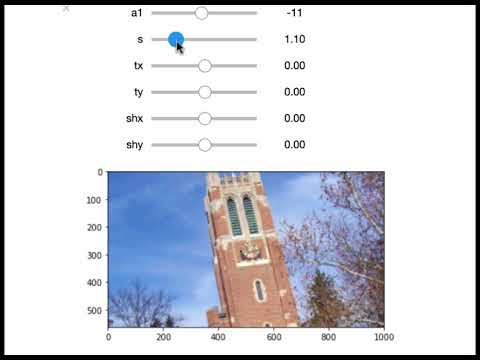

In [88]:
from IPython.display import YouTubeVideo
YouTubeVideo("b4x39uqTMBY",width=640,height=360)

In [89]:
forground = banner
background = billboard

def transform_and_plot(a=0,sx=0.5,sy=0.5, tx=0,ty=0, shx=0, shy=0):
    T = affine_transform(a=a,sx=sx, sy=sy,tx=tx,ty=ty,shx=shx, shy=shy)
    Tc = np.matrix([[1,0,-background.shape[1]/2], [0,1,-background.shape[0]/2], [0,0,1]])
    To = np.matrix([[1,0,forground.shape[1]/2], [0,1,forground.shape[0]/2], [0,0,1]])
    im_new = stitch_images(forground, background, To*T*Tc)
    plt.imshow(im_new);
    plt.show(); 


In [90]:
maxx = max(background.shape[0], forground.shape[0])
maxy = max(background.shape[1], forground.shape[1])
interact_manual(transform_and_plot, 
                a=(-180,180), 
                sx=(0.001,5, 0.01), 
                sy=(0.001,5, 0.01), 
                tx=(-maxx,maxx), 
                ty=(-maxy,maxy), 
                shx = (-1,1,0.01), 
                shy = (-1,1,0.01));

interactive(children=(IntSlider(value=0, description='a', max=180, min=-180), FloatSlider(value=0.5, descripti…


---
<a name=Stitching-the-Billboad-and-Example-images></a>
# 6. (10 points) Stitching the Billboad and Example images


Given what you learned above, record the angle (```a```), scaling (```sx,xy```), translation (```tx,ty```) and shear (```shx```,```shy```) values to generate the final transform that best fits the MSU banner image to the billboard image (similar to the image at the top of the homework).  

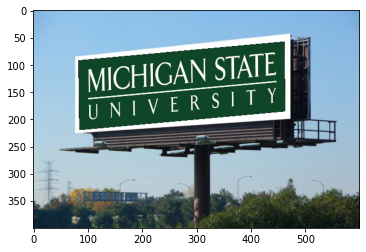

In [93]:
T = affine_transform(a=-4, 
                     sx=1.96,
                     sy=1.50,
                     tx=160,
                     ty=-150,
                     shx=0.04,
                     shy=0.00)

im_new = stitch_images(banner, billboard, T)
plt.imshow(im_new);



---
<a name=Be-creative></a>
# 7. (10 points) Be creative


Find two other examples images (include their URLs in the list at the top of this assignment).  Stitch them together in a fun and creative way and show your final results.

**_NOTE:_** Any purely black pixels (R,G,B = 0,0,0) in your foreground image will act transparent when using the provided ```stitch_images``` function. This can allow for non-square overlapping images. Have fun with it. 

&#9989;  **<font color=red>DO THIS:</font>** Write code to display your images here. Make sure your instructor can use the code above to download the correct images.

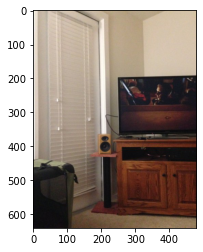

In [97]:
# Put your display code here.
plt.imshow(img_1);

&#9989;  **<font color=red>DO THIS:</font>** Design a transform to overlap one image with the other.

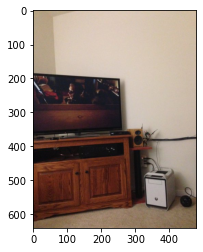

In [98]:
# Put your transform code here.
plt.imshow(img_2);


&#9989;  **<font color=red>DO THIS:</font>** stitch your images together using your transform.

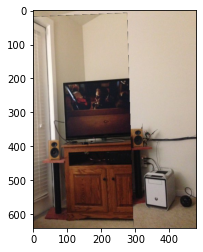

In [99]:
# Put your transform code here.
T = affine_transform(a=-2, 
                     sx=1.20,
                     sy=1.00,
                     tx=-150,
                     ty=-20,
                     shx=0.00,
                     shy=0.00)

im_new_2 = stitch_images(img_1, img_2, T)
plt.imshow(im_new_2);

&#9989;  **<font color=red>FEEDBACK:</font>** Please use the following cell to describe any problems you encountered and/or thoughts about this homework. Also feel free to describe how you picked your example. 

Put your comments/feedback in this cell.

---------
### Congratulations, we're done!


Written by Dirk Colbry, Michigan State University
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.